In [0]:
# import libraries
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

LBJ

In [0]:
url = 'https://www.basketball-reference.com/players/j/jamesle01/gamelog/2018/'
res = requests.get(url)
soup = BeautifulSoup(res.text, "html.parser")

In [0]:
table_rows = soup.find('div', {'class':'table_outer_container'}).find('tbody').find_all('tr')

table_body = []
for tr in table_rows:
  
  td = tr.find_all('td')
  row = [tr.text for tr in td]
  table_body.append(row)

In [0]:
th = soup.find('div', {'class':'table_outer_container'}).find('thead').find_all('th')
table_head = [tr.text for tr in th]

In [0]:
lbj_2018 = pd.DataFrame(table_body, columns=table_head[1:]).dropna().reset_index(drop=True)

JR Smith

In [0]:
url = 'https://www.basketball-reference.com/players/s/smithjr01/gamelog/2018/'
res = requests.get(url)
soup = BeautifulSoup(res.text, "html.parser")

In [0]:
table_rows = soup.find('div', {'class':'table_outer_container'}).find('tbody').find_all('tr')

table_body = []
for tr in table_rows:
  
  td = tr.find_all('td')
  row = [tr.text for tr in td]
  table_body.append(row)

In [0]:
th = soup.find('div', {'class':'table_outer_container'}).find('thead').find_all('th')
table_head = [tr.text for tr in th]

In [0]:
jr_2018 = pd.DataFrame(table_body, columns=table_head[1:]).dropna().reset_index(drop=True)

Extract "points", "assists" 

In [0]:
jr_data = jr_2018[['PTS','AST']].astype(int)
Y_jr = [0 for i in range(len(jr_data))]
lbj_data = lbj_2018[['PTS','AST']].astype(int)
Y_lbj = [1 for i in range(len(lbj_data))]

In [0]:
jr_data['label'] = Y_jr
lbj_data['label'] = Y_lbj

In [0]:
data_all = pd.concat([jr_data,lbj_data], axis=0).reset_index(drop=True)

Train SVM model

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data_all[['PTS','AST']], data_all[['label']], test_size=0.2, random_state=0)

In [14]:
from sklearn.svm import SVC

# "probability estimates" must be enabled prior to calling fit,
# and will slow down that method.
svm = SVC(kernel='linear', probability = True)
svm.fit(X_train, y_train['label'].values)
svm.predict(X_test)

array([0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0])

In [15]:
y_test['label'].values

array([0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0])

In [16]:
error = 0
for i, v in enumerate(svm.predict(X_test)):
    if v != y_test['label'].values[i]:
        error += 1
print(error)

0


Convert to string labels

In [0]:
data_classes = ['JR','LBJ']
d = dict(zip(range(len(data_classes)), data_classes))
y = np.vectorize(d.get)(y_train['label'].values)

In [0]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.01):
    

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    edgecolor='black',
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

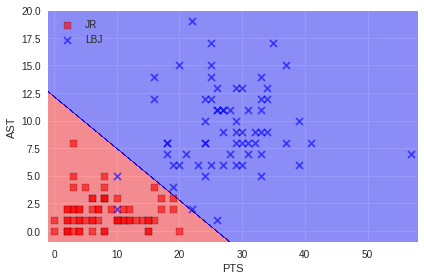

In [19]:
plot_decision_regions(X_train.values, y, classifier=svm)
plt.xlabel('PTS')
plt.ylabel('AST')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()